# Imports 

In [108]:
import pandas as pd

from ast import literal_eval

import re
import json

from tqdm import tqdm
tqdm.pandas()

import urlexpander

from sklearn.model_selection import train_test_split

from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt

from rouge_score import rouge_scorer
from torchmetrics.text.bert import BERTScore
from nltk.translate import bleu_score

# Settings and Configuration 

In [104]:
DATA_BASE      = '../../data/'
FLIPSIDE_DATA  = DATA_BASE + '/webpage_data/full_flipside_data_clean.csv'
TWITTER_DATA   = DATA_BASE + 'twitter_data/all_tweet_data.csv'
REDDIT_DATA    = DATA_BASE + 'reddit_data/all_reddit.csv'

FINAL_OUT_FP   = DATA_BASE + '/data_clean/polisum_raw.csv'
CLEAN_OUT_FP   = DATA_BASE + '/data_clean/polisum_clean.csv'
LEFT_OUT_FP    = DATA_BASE + '/data_clean/polisum_left.csv'
RIGHT_OUT_FP   = DATA_BASE + '/data_clean/polisum_right.csv'
SINGLE_OUT_FP  = DATA_BASE + '/data_clean/polisum_one_side.csv'
COCOSUM_FP     = DATA_BASE + '/data_clean/polisum_cocosum/'

MIN_TOKS       = 7
SENT_SPLIT_TOK = '|||'
PRIMERA_TOK    = '<doc-sep>'
LEFT_TOK       = '<LEFT> '
RIGHT_TOK      = '<RIGHT> '

PLOT_STYLE     = 'fivethirtyeight'

# Reading & Preparing Data 

In [3]:
flipside = pd.read_csv(FLIPSIDE_DATA)
twitter = pd.read_csv(TWITTER_DATA)
reddit  = pd.read_csv(REDDIT_DATA)

C:\Users\ndeas\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3343: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Cleaning Data

In [4]:
URL_REGEX = '(?!mailto:)(?:(?:http|https|ftp)://)(?:\\S+(?::\\S*)?@)?(?:(?:(?:[1-9]\\d?|1\\d\\d|2[01]\\d|22[0-3])(?:\\.(?:1?\\d{1,2}|2[0-4]\\d|25[0-5])){2}(?:\\.(?:[0-9]\\d?|1\\d\\d|2[0-4]\\d|25[0-4]))|(?:(?:[a-z\\u00a1-\\uffff0-9]+-?)*[a-z\\u00a1-\\uffff0-9]+)(?:\\.(?:[a-z\\u00a1-\\uffff0-9]+-?)*[a-z\\u00a1-\\uffff0-9]+)*(?:\\.(?:[a-z\\u00a1-\\uffff]{2,})))|localhost)(?::\\d{2,5})?(?:(/|\\?|#)[^\\s]*)?'

In [28]:
def filter_urls(text):
    new_text = re.sub(URL_REGEX, '<URL>', text)
    return new_text

In [29]:
def split_sents(text):
    posts = text.split(SENT_SPLIT_TOK)
    sents = [sent for post in posts for sent in tokenize.sent_tokenize(post)]
    return SENT_SPLIT_TOK.join(sents)

In [36]:
def reorder_sm_text(row):
    tw_text = str(row['twitter_text']).split(SENT_SPLIT_TOK)
    re_text = str(row['reddit_text']).split(SENT_SPLIT_TOK)
    
    tw_text.sort(key = len, reverse = True)
    re_text.sort(key = len, reverse = True)
    
    match_len, larger = 0, []
    if len(tw_text) > len(re_text):
        match_len = len(re_text)
        larger = tw_text
    else:
        match_len = len(tw_text)
        larger = re_text
    
    comb_text = [''] * (2 * match_len)
    comb_text[::2] = tw_text[:match_len]
    comb_text[1::2] = re_text[:match_len]
    comb_text += larger[match_len:]
    
    return SENT_SPLIT_TOK.join(comb_text)

## Flipside 

In [8]:
flipside['date'] = pd.to_datetime(flipside['date'])
flipside = flipside.astype(str)

## Reddit 

In [9]:
reddit['title'] = reddit['title'].fillna('')
reddit['selftext'] = reddit['selftext'].fillna('')
reddit['text'] = reddit['title'] + ' ' + reddit['selftext']

In [10]:
reddit['no_url_text'] = reddit['text'].progress_apply(filter_urls)

100%|████████████████████████████████████████████████████████████████████████| 14191/14191 [00:00<00:00, 170110.14it/s]


In [11]:
reddit_clean = reddit[reddit['no_url_text'].str.replace('(<URL>)', '', regex = True).str.split(' ').apply(len) > MIN_TOKS]

In [12]:
reddit_clean = reddit_clean[['title_q', 'date_q', 'no_url_text']]
reddit_clean['date_q'] = pd.to_datetime(reddit_clean['date_q'])
reddit_clean = reddit_clean.astype(str)

In [13]:
reddit_texts = reddit_clean.groupby(['title_q','date_q'])['no_url_text']
reddit_texts = reddit_texts.transform(lambda texts: SENT_SPLIT_TOK.join(texts))
reddit_clean['no_url_text'] = reddit_texts

In [14]:
reddit_clean = reddit_clean.drop_duplicates().reset_index(drop = True)

In [15]:
reddit_clean['texts'] = reddit_clean['no_url_text'].progress_apply(split_sents)

100%|██████████████████████████████████████████████████████████████████████████████| 971/971 [00:00<00:00, 2101.22it/s]


## Twitter 

In [16]:
twitter['no_url_text'] = twitter['text'].progress_apply(filter_urls)

100%|████████████████████████████████████████████████████████████████████████| 34134/34134 [00:00<00:00, 117723.30it/s]


In [17]:
twitter_clean = twitter[twitter['no_url_text'].str.replace('(<URL>)', '', regex = True).str.split(' ').apply(len) > MIN_TOKS]

In [18]:
twitter_clean = twitter_clean[['title_q', 'date_q', 'no_url_text']]
twitter_clean['date_q'] = pd.to_datetime(twitter_clean['date_q'])
twitter_clean = twitter_clean.astype(str)

In [19]:
tweet_texts = twitter_clean.groupby(['title_q','date_q'])['no_url_text']
tweet_texts = tweet_texts.transform(lambda texts: SENT_SPLIT_TOK.join(texts))
twitter_clean['no_url_text'] = tweet_texts

In [20]:
twitter_clean = twitter_clean.drop_duplicates().reset_index(drop = True)

In [21]:
twitter_clean['texts'] = twitter_clean['no_url_text'].progress_apply(split_sents)

100%|███████████████████████████████████████████████████████████████████████████████| 977/977 [00:01<00:00, 508.90it/s]


# Consolidation 

In [22]:
sm_texts = reddit_clean.merge(twitter_clean, on = ['title_q', 'date_q'], how = 'outer')

In [23]:
sm_texts = sm_texts[['title_q', 'date_q', 'texts_x',  'texts_y']]
sm_texts.columns = ['title', 'date', 'reddit_text', 'twitter_text']
sm_texts = sm_texts.fillna('').astype(str)

In [24]:
sm_texts['sm_text'] = sm_texts['reddit_text'] + SENT_SPLIT_TOK + sm_texts['twitter_text']
sm_texts['sm_text'] = sm_texts['sm_text'].progress_apply(lambda text: re.sub('^\s*\|\|\|', '', text))

100%|█████████████████████████████████████████████████████████████████████████████| 977/977 [00:00<00:00, 15263.66it/s]


In [25]:
sm_texts['num_reddit'] = sm_texts['reddit_text'].progress_apply(lambda text: len(text.split('|||')))
sm_texts['num_twitter'] = sm_texts['twitter_text'].progress_apply(lambda text: len(text.split('|||')))
sm_texts['num_sm'] = sm_texts['sm_text'].progress_apply(lambda text: len(text.split('|||')))

100%|█████████████████████████████████████████████████████████████████████████████| 977/977 [00:00<00:00, 54175.50it/s]


In [26]:
polisum = flipside.merge(sm_texts, on = ['title', 'date'])

# Saving Polisum Variants 

In [27]:
polisum.to_csv(FINAL_OUT_FP, index = None)

In [11]:
sid = SentimentIntensityAnalyzer()

In [42]:
def get_sentiments(text):
    '''
        Scores each sentence in text by sentiment, sorts the sentences,
            and splits the sentences in half
    '''
    
    text_l = re.split(r'\|\|\|', text)
    text_l = [t for t in text_l if t != '']
    
    sent_scores = []
    for sent in text_l:
        sentiments = sid.polarity_scores(sent)
        sent_scores.append(sentiments)
    
    text_sents = [(text, sent['compound']) for text, sent in zip(text_l, sent_scores)]
    text_sents.sort(key = lambda s: s[1])
    
    pos_text = [text for text, _ in text_sents[:len(text_sents)//2]]
    neg_text = [text for text, _ in text_sents[len(text_sents)//2:]]
    
    return '|||'.join(pos_text), '|||'.join(neg_text)

def get_sentiments_row(row):
    text = str(row['sm_text'])
    pos, neg = get_sentiments(text)
    
    row['h1_text'] = pos
    row['h2_text'] = neg
    
    return row

In [116]:
# Filter out rows that do not contain reference summaries
polisum_clean = polisum_clean[~polisum_clean['left_sum'].isna()]
polisum_clean = polisum_clean[~polisum_clean['right_sum'].isna()]

In [44]:
polisum_clean = polisum_clean.progress_apply(get_sentiments_row, axis = 1)

100%|████████████████████████████████████████████████████████████████████████████████| 977/977 [00:13<00:00, 72.68it/s]


In [45]:
# Change splitting string to the same as sm_text, '|||'
polisum_clean['right_op'] = polisum_clean['right_op'].str.replace('\|+', SENT_SPLIT_TOK)
polisum_clean['left_op'] = polisum_clean['left_op'].str.replace('\|+', SENT_SPLIT_TOK)

C:\Users\ndeas\miniconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
C:\Users\ndeas\miniconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
# Reorder social media to alternate between twitter and reddit
polisum_clean['sm_text'] = polisum_clean.progress_apply(reorder_sm_text, axis = 1)

100%|█████████████████████████████████████████████████████████████████████████████| 977/977 [00:00<00:00, 15177.05it/s]


In [47]:
# Replace usernames with <UNAME> token
polisum_clean['sm_text'] = polisum_clean['sm_text'].str.replace('@[A-Za-z0-9_]+', '<UNAME>', regex = True)
polisum_clean['sm_text_primera'] = polisum_clean['sm_text'].str.replace(SENT_SPLIT_TOK.replace('|', '\|'), PRIMERA_TOK)
polisum_clean = polisum_clean.reset_index(drop = True)

C:\Users\ndeas\miniconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [119]:
polisum_left = polisum_clean.drop('right_sum', axis = 1)
polisum_left['perspective'] = 'left'
polisum_left['sm_text'] = LEFT_TOK + ' ' + polisum_left['sm_text']
polisum_left['sm_text_primera'] = LEFT_TOK + ' ' + polisum_left['sm_text_primera']
polisum_left = polisum_left.rename({'left_sum': 'ref_sum'}, axis = 1)

polisum_right = polisum_clean.drop('left_sum', axis = 1)
polisum_right['perspective'] = 'right'
polisum_right['sm_text'] = RIGHT_TOK + ' ' + polisum_right['sm_text']
polisum_right['sm_text_primera'] = RIGHT_TOK + ' ' + polisum_right['sm_text_primera']
polisum_right = polisum_right.rename({'right_sum': 'ref_sum'}, axis = 1)

In [120]:
polisum_side = pd.concat([polisum_left, polisum_right], axis = 0).reset_index(drop = True)

In [121]:
# Save all cleaned datasets
polisum_clean.to_csv(CLEAN_OUT_FP, index = False)
polisum_left.to_csv(LEFT_OUT_FP, index = False)
polisum_right.to_csv(RIGHT_OUT_FP, index = False)
polisum_side.to_csv(SINGLE_OUT_FP, index = False)

In [127]:
polisum_coco = polisum_clean[['title', 'date', 'h1_text', 'h2_text', 'left_sum', 'right_sum']]

In [128]:
polisum_coco['h1_text'] = polisum_coco['h1_text'].progress_apply(lambda s: s.split(SENT_SPLIT_TOK))
polisum_coco['h2_text'] = polisum_coco['h2_text'].progress_apply(lambda s: s.split(SENT_SPLIT_TOK))

100%|█████████████████████████████████████████████████████████████████████████████| 735/735 [00:00<00:00, 36086.69it/s]
C:\Users\ndeas\miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
100%|█████████████████████████████████████████████████████████████████████████████| 735/735 [00:00<00:00, 50325.90it/s]
C:\Users\ndeas\miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

In [129]:
polisum_test_coco, polisum_dev_coco = train_test_split(polisum_coco, test_size = 0.2) 

In [131]:
# Converts dataset into format expected by cocosum
# Samples outputted as json with keys entity_a, entity_a_summary, entity_a_uid, the same colums for entity b, and common summary
polisum_dev_jsonl = []
for sdict in polisum_dev_coco.to_dict(orient = 'records'):
    coco_data = {
        f'entity_a': sdict['title'] + '_' + sdict['date'] + '_l',
        f'entity_b': sdict['title'] + '_' + sdict['date'] + '_r',
        f'entity_a_summary': sdict['left_sum'],
        f'entity_b_summary': sdict['right_sum'],
        f'common_summary': str(sdict['left_sum']) + ' ' + str(sdict['right_sum']),
        f'entity_a_uid': ['uid' for _ in sdict['h1_text']],
        f'entity_b_uid': ['uid' for _ in sdict['h2_text']],
        f'entity_a_reviews': sdict['h1_text'],
        f'entity_b_reviews': sdict['h2_text']
    }
    polisum_dev_jsonl.append(coco_data)
with open(COCOSUM_FP + 'dev.json', 'w', encoding = 'utf-8') as f:
    json.dump(polisum_dev_jsonl, f)
    
polisum_test_jsonl = []
for sdict in polisum_test_coco.to_dict(orient = 'records'):
    coco_data = {
        f'entity_a': sdict['title'] + '_' + sdict['date'] + '_l',
        f'entity_b': sdict['title'] + '_' + sdict['date'] + '_r',
        f'entity_a_summary': sdict['left_sum'],
        f'entity_b_summary': sdict['right_sum'],
        f'common_summary': str(sdict['left_sum']) + ' ' + str(sdict['right_sum']),
        f'entity_a_uid': ['uid' for _ in sdict['h1_text']],
        f'entity_b_uid': ['uid' for _ in sdict['h2_text']],
        f'entity_a_reviews': sdict['h1_text'],
        f'entity_b_reviews': sdict['h2_text']
    }
    polisum_test_jsonl.append(coco_data)
with open(COCOSUM_FP + 'test.json', 'w', encoding = 'utf-8') as f:
    json.dump(polisum_test_jsonl, f)

# Polisum Data Summary

## Functions 

In [36]:
def get_ngrams(text, ngram = 1):
    return zip(*[str(text).split()[i:] for i in range(ngram)])

def get_novel_ngrams(ref, source, ngrams = (1, 2, 3, 4)):
    diffs = []
    for ngram in ngrams:
        ref_ng = get_ngrams(ref, ngram = ngram)
        src_ng = get_ngrams(source, ngram = ngram)
        diff = set(ref_ng).difference(src_ng)
        diffs.append(len(diff))
    
    return diffs
        
def calc_novel_ngrams_row(row):
    text = row['sm_text']
    refl = row['left_sum']
    refr = row['right_sum']
    
    nov_ngramsl = get_novel_ngrams(refl, text)
    nov_ngramsr = get_novel_ngrams(refr, text)
    
    return nov_ngramsl, nov_ngramsr

In [37]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer = True)
def get_max_rouge(row):
    left_sum = row['left_sum']
    right_sum = row['right_sum']
    
    stext = re.split(SENT_SPLIT_TOK.replace('|', '\|'), row['sm_text'])
    
    lscores, rscores = [], []
    for text in stext:
        lscores.append(scorer.score(str(left_sum), str(text)))
        rscores.append(scorer.score(str(right_sum), str(text)))
    
    l_text_scores = list(zip(stext, lscores))
    r_text_scores = list(zip(stext, rscores))
    
    max_l = get_max_scores(l_text_scores)
    max_r = get_max_scores(r_text_scores)
    
    return max_l, max_r
        
def get_max_scores(scores, maximize = 'rouge2'):
    scores.sort(key = lambda score: score[1][maximize].fmeasure, reverse = True)
    return scores[0]

def reformat_rouge(rouge_scores):
    rouges = {rtype: {'prec': [], 'rec': [], 'f1': []} for rtype in ('rouge1', 'rouge2', 'rougeL')}
    
    for text_score in rouge_scores:
        for rtype in ('rouge1', 'rouge2', 'rougeL'):
            rouges[rtype]['prec'].append(text_score[1][rtype].precision)
            rouges[rtype]['rec'].append(text_score[1][rtype].recall)
            rouges[rtype]['f1'].append(text_score[1][rtype].fmeasure)
    
    return rouges

## Statistics 

In [38]:
polisum = pd.read_csv(CLEAN_OUT_FP)

### Lengths 

In [39]:
avg_num_twitter = polisum['num_twitter'].mean()
avg_num_reddit  = polisum['num_reddit'].mean()
avg_num_comb    = polisum['num_sm'].mean()
std_num_comb    = polisum['num_sm'].std()

avg_len_left    = polisum['left_sum'].str.split(' ').apply(len).mean()
avg_len_right   = polisum['right_sum'].str.split(' ').apply(len).mean()
std_len_left    = polisum['left_sum'].str.split(' ').apply(len).std()
std_len_right   = polisum['right_sum'].str.split(' ').apply(len).std()

### Novel N-Grams 

In [40]:
novel_ngrams = polisum.progress_apply(calc_novel_ngrams_row, axis = 1)
novel_l = [nngrams[0] for nngrams in novel_ngrams]
novel_r = [nngrams[1] for nngrams in novel_ngrams]

novel_l_dict = {1: 0, 2: 0, 3: 0, 4: 0}
novel_r_dict = {1: 0, 2: 0, 3: 0, 4: 0}

for nov_list in novel_l:
    for i, nov_cnt in enumerate(nov_list):
        novel_l_dict[i+1] += nov_cnt
for nov_list in novel_r:
    for i, nov_cnt in enumerate(nov_list):
        novel_r_dict[i+1] += nov_cnt

100%|███████████████████████████████████████████████████████████████████████████████| 735/735 [00:01<00:00, 530.62it/s]


In [41]:
tot_ref_len_l = sum(polisum['left_sum'].str.split().apply(lambda tl: len(tl) if isinstance(tl, list) else 1))
tot_ref_len_r = sum(polisum['right_sum'].str.split().apply(lambda tl: len(tl) if isinstance(tl, list) else 1))

novel_l_dict = {key: (1. * val) / (tot_ref_len_l - (key - 1.)) for key, val in novel_l_dict.items()}
novel_r_dict = {key: (1. * val) / (tot_ref_len_r - (key - 1.)) for key, val in novel_r_dict.items()}

### Rouge Scores 

In [42]:
# Maximum Rouge Scores
all_rouge_scores = polisum.progress_apply(get_max_rouge, axis = 1)

100%|████████████████████████████████████████████████████████████████████████████████| 735/735 [01:13<00:00, 10.02it/s]


In [43]:
left_text_scores  = [score_pair[0] for score_pair in all_rouge_scores]
right_text_scores = [score_pair[1] for score_pair in all_rouge_scores]

left_texts        = [score[0] for score in left_text_scores]
right_texts       = [score[0] for score in right_text_scores]
left_rscores      = reformat_rouge(left_text_scores)
right_rscores     = reformat_rouge(right_text_scores)

In [44]:
left_rscores = {rtype: {metric: sum(scores)/len(scores) for metric, scores in rouge_scores.items()} for rtype, rouge_scores in left_rscores.items()}
right_rscores = {rtype: {metric: sum(scores)/len(scores) for metric, scores in rouge_scores.items()} for rtype, rouge_scores in right_rscores.items()}

### Self-Bleu

In [45]:
def get_self_bleus(preds1, preds2):
    self_bleus = []
    for pred1, pred2 in zip(preds1, preds2):
        bleu = bleu_score.sentence_bleu(pred1, pred2, weights = (1.0,))
        self_bleus.append(bleu)
    return self_bleus

In [46]:
self_bleus = get_self_bleus(left_texts, right_texts)
self_bleu  = sum(self_bleus)/len(self_bleus)

### BERT-Score 

In [47]:
bert_scorer = BERTScore(model_name_or_path = 'roberta-large-mnli', 
                        rescale_with_baseline = True, 
                        lang = 'en',
                        verbose = True)

In [48]:
l_bscores = bert_scorer(left_texts, polisum['left_sum'].astype(str).tolist())
r_bscores = bert_scorer(right_texts, polisum['right_sum'].astype(str).tolist())

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaModel: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaModel: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

In [49]:
l_bscore = sum(l_bscores['f1'])/len(l_bscores['f1'])
r_bscore = sum(r_bscores['f1'])/len(r_bscores['f1'])

## Statistics Summary 

In [50]:
print('---Polisum Statistics---')
print(f'Avg. Num Twitter:    {avg_num_twitter:.2f}')
print(f'Avg. Num Reddit:     {avg_num_reddit:.2f}')
print(f'Avg. Num Comb:       {avg_num_comb:.2f} ({std_num_comb:.2f})')
print(f'Avg. Len Left:       {avg_len_left:.2f} ({std_len_left:.2f})')
print(f'Avg. Len Right:      {avg_len_right:.2f} ({std_len_right:.2f})')
print(f'Novel Left N-grams:  {" ".join([str(n) + "-" + str(perc * 100.)[:5] for n, perc in novel_l_dict.items()])}')
print(f'Novel Right N-grams: {" ".join([str(n) + "-" + str(perc * 100.)[:5] for n, perc in novel_r_dict.items()])}')
print('--------------------------------------')
print(f'                     Left   |  Right')
print(f'                     -------+-------')
print(f'Rouge-1:             {left_rscores["rouge1"]["f1"]*100.:5.2f}  |  {right_rscores["rouge1"]["f1"]*100.:5.2f}')
print(f'Rouge-2:             {left_rscores["rouge2"]["f1"]*100.:5.2f}  |  {right_rscores["rouge2"]["f1"]*100.:5.2f}')
print(f'Rouge-L:             {left_rscores["rougeL"]["f1"]*100.:5.2f}  |  {right_rscores["rougeL"]["f1"]*100.:5.2f}')
print(f'BERT-Score:          {l_bscore*100.:5.2f}  |  {r_bscore*100.:5.2f}')
print(f'Self-BLEU:                {self_bleu*100.:5.2f}')

---Polisum Statistics---
Avg. Num Twitter:    63.44
Avg. Num Reddit:     14.89
Avg. Num Comb:       78.33 (20.31)
Avg. Len Left:       17.09 (5.92)
Avg. Len Right:      16.93 (5.96)
Novel Left N-grams:  1-48.03 2-87.75 3-87.47 4-82.14
Novel Right N-grams: 1-47.17 2-87.56 3-87.33 4-82.07
--------------------------------------
                     Left   |  Right
                     -------+-------
Rouge-1:             22.45  |  22.25
Rouge-2:              8.77  |   8.67
Rouge-L:             19.06  |  19.11
BERT-Score:          13.51  |  15.51
Self-BLEU:                26.59


## Plots 

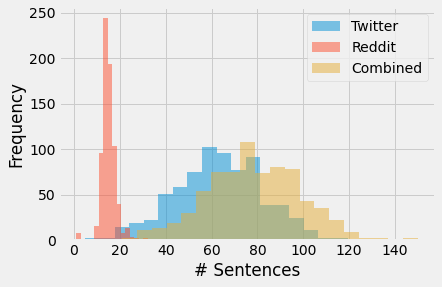

In [51]:
# Plot histogram of source sentence counts
with plt.style.context(PLOT_STYLE):
    plt.hist(polisum['num_twitter'], alpha = 0.5, label = 'Twitter', bins = 20)
    plt.hist(polisum['num_reddit'], alpha = 0.5, label = 'Reddit', bins = 20)
    plt.hist(polisum['num_sm'], alpha = 0.5, label = 'Combined', bins = 20)

    plt.legend()
    plt.ylabel('Frequency')
    plt.xlabel('# Sentences')
    plt.savefig('../../results/source_length_histogram.png', dpi = 100)

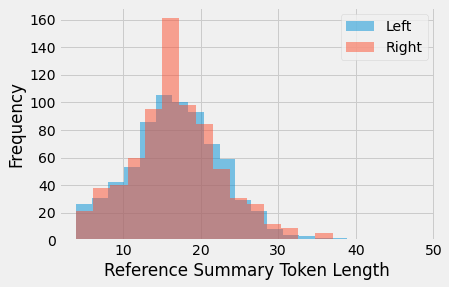

In [52]:
# Plot histogram of reference summary lengths
with plt.style.context(PLOT_STYLE):
    plt.hist(polisum['left_sum'].str.split(' ').apply(len), alpha = 0.5, label = 'Left', bins = 20)
    plt.hist(polisum['right_sum'].str.split(' ').apply(len), alpha = 0.5, label = 'Right', bins = 20)

    plt.legend()
    plt.ylabel('Frequency')
    plt.xlabel('Reference Summary Token Length')
    plt.savefig('../../results/ref_length_histogram.png', dpi = 100)